In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Performance over time

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

# from src.bill_passage.model_analysis_functions import fetch_evaluations_models, fetch_all_evaluations_for_model

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

In [9]:
# experiment_hash = 'b46a01d51e0c4b511e4a1aacd182a811'
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master'

# experiment_hash = '102f4996db3d114aa68dda958d1446cc'
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_new2'

# experiment_hash = 'dc52ec9e21af7cceb2abd22e876040dd'
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_new2'

# experiment_hash = '170870efbfa049eff695a0423dfe5ea8'
experiment_hash = '5bf28511f823b995bb5f843574ba2282'
project_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'

#### Model group evaluations

In [10]:
metric='precision@'
param = '10_pct'

In [11]:
eval_q = """
        select 
            model_group_id,
            model_id,
            train_end_time,
            metric,
            parameter,
            model_type,
            hyperparameters,
            stochastic_value as metric_value
        from triage_metadata.experiment_models join triage_metadata.models using(model_hash) join test_results.evaluations e using(model_id)
        where experiment_hash='{}'
        and metric='{}'
        and parameter='{}'
        and subset_hash=''
"""

precision_all = pd.read_sql(eval_q.format(experiment_hash, metric, param), db_conn)

In [12]:
# precision_all

Text(0.5, 1.0, 'precision@10_pct over time for the model groups tested')

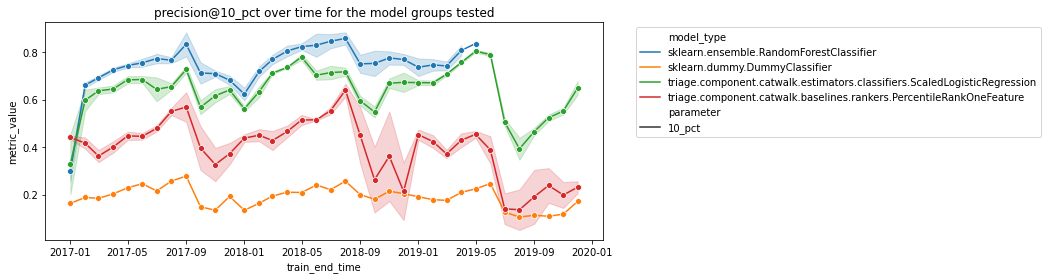

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=precision_all, x='train_end_time', y='metric_value', 
             hue='model_type', 
             marker='o', 
             style='parameter', 
             estimator='mean', ci='sd')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('{}{} over time for the model groups tested'.format(metric, param))

In [17]:
msk = precision_all['model_type'].str.contains('Percentile')

precision_all[msk]

,model_group_id,model_id,train_end_time,metric,parameter,model_type,hyperparameters,metric_value
38,729,17005,2018-04-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.448484
61,729,17034,2018-07-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.564619
78,733,16988,2018-02-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.468128
80,733,16942,2017-09-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.524611
92,733,17004,2018-04-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.483437
...,...,...,...,...,...,...,...,...
740,733,17069,2018-11-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.227979
782,733,17060,2018-10-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.165498
789,733,16924,2017-07-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.469514
797,733,16950,2017-10-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.330775


#### Recall at k_pct for the model groups

In [18]:
recall = pd.read_sql(
    eval_q.format(
        experiment_hash, 'recall@', '10_pct' 
    ),
    db_conn
)

Text(0.5, 1.0, 'recall@k_pct over time for the model groups tested')

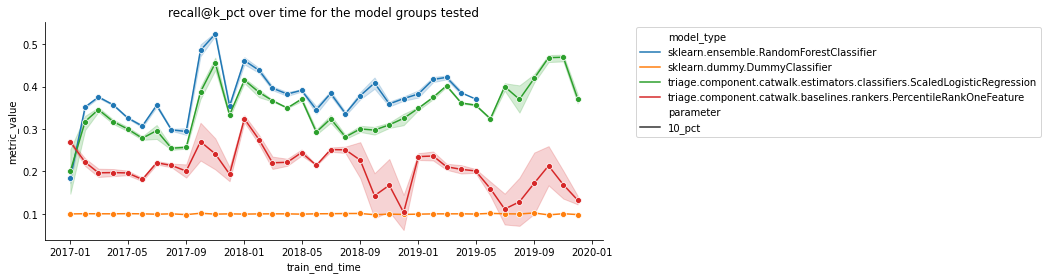

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.lineplot(data=recall, x='train_end_time', y='metric_value', hue='model_type', marker='o', style='parameter')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('recall@k_pct over time for the model groups tested')

In [43]:
# msk = precision_all['model_type'].str.contains('Random')
# sns.lineplot(data=precision_all[msk], x='train_end_time', y='metric_value', hue='model_type', marker='o', estimator='mean', ci='sd')
# plt.legend(bbox_to_anchor=(1.05, 1))

In [44]:
# precision_all[msk]['model_group_id'].unique()

In [22]:
msk2 = precision_all['model_group_id'] == 729
precision_all[msk2].sort_values('train_end_time')

,model_group_id,model_id,train_end_time,metric,parameter,model_type,hyperparameters,metric_value
327,729,16864,2017-01-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.434876
188,729,16881,2017-02-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.400119
569,729,16888,2017-03-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.344386
450,729,16899,2017-04-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.383884
673,729,16907,2017-05-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.435015
362,729,16915,2017-06-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.435503
473,729,16926,2017-07-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.487534
547,729,16934,2017-08-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.561323
434,729,16943,2017-09-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.612694
169,729,16951,2017-10-01,precision@,10_pct,triage.component.catwalk.baselines.rankers.Per...,"{'descend': False, 'feature': 'sp_success_enti...",0.461270


#### PR curve for a model

In [23]:
row = precision_all[msk2].sample(1)
model_id = row['model_id'].iloc[0]
train_end_time = row['train_end_time'].iloc[0]

model_id, train_end_time

(16926, Timestamp('2017-07-01 00:00:00'))

In [24]:

# model_id=16722

# msk = precision_all['model_id'] == model_id
# train_end_time = precision_all[msk]['train_end_time'].iloc[0]

q = """
    select 
        model_id,
        parameter,
        metric,
        stochastic_value
    from test_results.evaluations
    where model_id={} and subset_hash=''
""".format(
    model_id
)

eval_model=pd.read_sql(q, db_conn)

In [25]:
eval_model['perc_points'] = [x.split('_')[0] for x in eval_model['parameter'].tolist()]
eval_model['perc_points'] = pd.to_numeric(eval_model['perc_points'])
# eval_model.sort_values('perc_points', inplace=True)

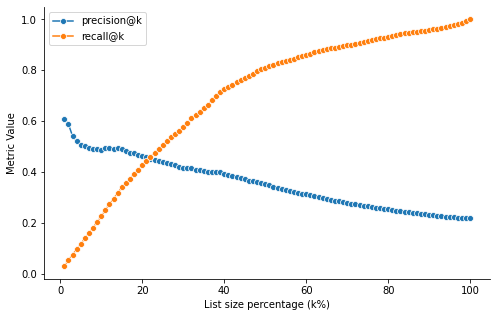

In [26]:
msk_prec = eval_model['metric']=='precision@'
msk_recall = eval_model['metric']=='recall@'
msk_pct = eval_model['parameter'].str.contains('pct')

df = eval_model[msk_pct]

fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x='perc_points', y='stochastic_value', data=eval_model[msk_pct & msk_prec], label='precision@k', marker='o', ax=ax, estimator='mean', ci='sd')
sns.lineplot(x='perc_points', y='stochastic_value', data=eval_model[msk_pct & msk_recall], label='recall@k', marker='o', ax=ax, estimator='mean', ci='sd')
ax.set_xlabel('List size percentage (k%)')
ax.set_ylabel('Metric Value')
# ax.set_title('Precision and Recall over time at Different Thresholds for All Logistic Regression Models'.format(mod_group))
sns.despine()

#### Feature importance (for a model)

In [109]:
q = """
    select * from train_results.feature_importances
    where model_id={} and rank_abs <=20
    order by rank_abs
"""

feature_importance_model = pd.read_sql(q.format(model_id), db_conn)

In [110]:
feature_importance_model.head(5)

,model_id,feature,feature_importance,rank_abs,rank_pct
0,15058,sp_success_entity_id_all_success_rate_max,0.052766,1,0.006494
1,15058,sp_success_entity_id_all_success_rate_avg,0.045535,2,0.012987
2,15058,evnt_cts_entity_id_all_action_count,0.042397,3,0.019481
3,15058,evnt_cts_entity_id_all_DISTINCT chamber_count,0.042296,4,0.025974
4,15058,evnt_cts_entity_id_all_important_sum,0.037677,5,0.032468


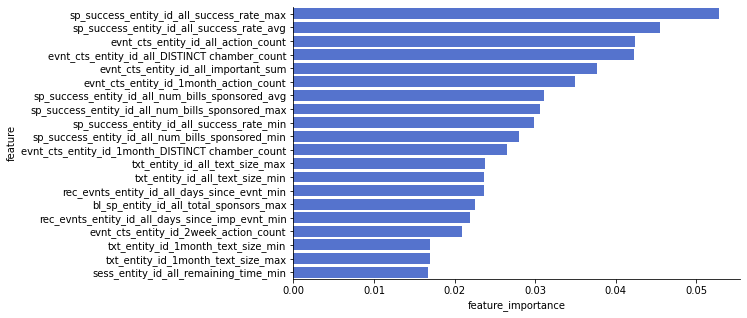

In [111]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(
    data=feature_importance_model,
    x='feature_importance',
    y='feature',
    color='royalblue'
)
sns.despine()

#### Subset evaluations

In [112]:
q = """select * from triage_metadata.subsets"""

subsets = pd.read_sql(q, db_conn)
subsets

,subset_hash,config,created_timestamp
0,1f609a1bb876ccbdfcb706c2c311c4a0,"{'name': 'at_intro', 'query': 'SELECT bill_id ...",2021-03-18 05:57:54.148907+00:00
1,b9bd1a3d07fbfdd21c4b79104f3acd4a,"{'name': 'in_1d', 'query': 'SELECT bill_id as ...",2021-03-18 05:58:16.486045+00:00
2,24ef6a456f60e172941accc06159eb14,"{'name': 'within_1w', 'query': 'SELECT bill_id...",2021-03-18 06:00:24.548230+00:00
3,e8e8bb06cdc9e9cb6b95e1f20bff89ec,"{'name': 'within_2w', 'query': 'SELECT bill_id...",2021-03-18 06:03:23.452646+00:00
4,3129a5294c9142acb49e6b4a583945fe,"{'name': 'within_1m', 'query': 'SELECT bill_id...",2021-03-18 06:09:54.446384+00:00
5,ad28251234980aa3b2ed12d420d9440c,"{'name': 'older_than_1m', 'query': 'SELECT bil...",2021-03-19 01:06:39.141738+00:00


In [113]:
# idx = 1
# subset_to_eval = subsets['subset_hash'].at[idx]
# subset_name = subsets['config'].at[idx]['name']

In [114]:
# q = """
#     select 
#         model_id,
#         parameter,
#         metric,
#         stochastic_value
#     from test_results.evaluations
#     where model_id={} and subset_hash='{}'
# """.format(
#     model_id, subset_to_eval
# )

# eval_subset = pd.read_sql(q, db_conn)

In [101]:
# eval_subset['perc_points'] = [x.split('_')[0] for x in eval_subset['parameter'].tolist()]
# eval_subset['perc_points'] = pd.to_numeric(eval_subset['perc_points'])


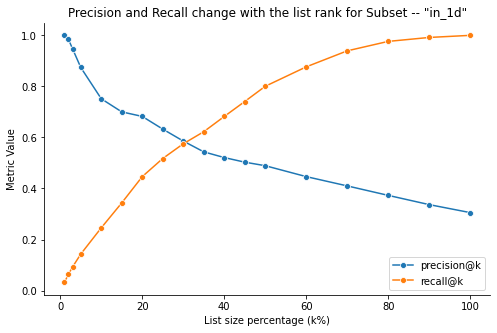

In [102]:
# msk_prec = eval_subset['metric']=='precision@'
# msk_recall = eval_subset['metric']=='recall@'
# msk_pct = eval_subset['parameter'].str.contains('pct')

# df = eval_subset[msk_pct]

# fig, ax = plt.subplots(figsize=(8,5))
# sns.lineplot(x='perc_points', y='stochastic_value', data=eval_subset[msk_pct & msk_prec], label='precision@k', marker='o', ax=ax, estimator='mean', ci='sd')
# sns.lineplot(x='perc_points', y='stochastic_value', data=eval_subset[msk_pct & msk_recall], label='recall@k', marker='o', ax=ax, estimator='mean', ci='sd')
# ax.set_xlabel('List size percentage (k%)')
# ax.set_ylabel('Metric Value')
# ax.set_title('Precision and Recall change with the list rank for Subset -- "{}"'.format(subset_name))
# sns.despine()

#### All subsets side-by-side

In [129]:
row = precision_all[msk2].sample(1)
model_id = row['model_id'].iloc[0]
train_end_time = row['train_end_time'].iloc[0]

model_id, train_end_time

(14421, Timestamp('2014-03-01 00:00:00'))

In [130]:
num_subsets = len(subsets)
subset_evaluations = list()
for i in range(num_subsets):
    subset_to_eval = subsets['subset_hash'].at[i]
    subset_name = subsets['config'].at[i]['name']
    
    q = """
        select 
            model_id,
            parameter,
            metric,
            stochastic_value
        from test_results.evaluations
        where model_id={} and subset_hash='{}'
    """.format(
        model_id, subset_to_eval
    )

    df = pd.read_sql(q, db_conn)
    subset_evaluations.append(df)

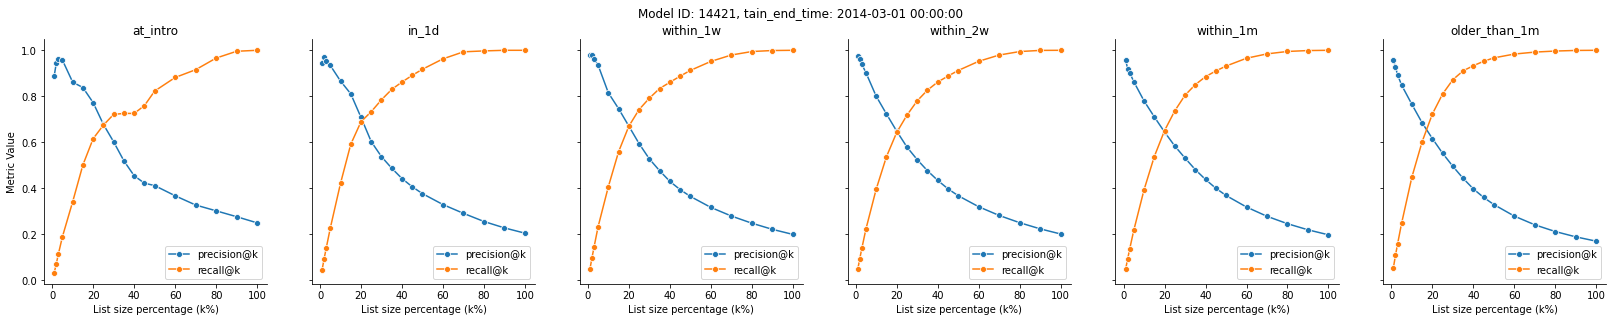

In [131]:
fig, axes = plt.subplots(1, num_subsets, figsize=(28, 4.5), sharex=True, sharey=True)
fig.suptitle('Model ID: {}, tain_end_time: {}'.format(model_id, train_end_time))
for i in range(num_subsets):
    subset_name = subsets['config'].at[i]['name']
    df = subset_evaluations[i]
    ax = axes[i]
    
    df['perc_points'] = [x.split('_')[0] for x in df['parameter'].tolist()]
    df['perc_points'] = pd.to_numeric(df['perc_points'])

    msk_prec = df['metric']=='precision@'
    msk_recall = df['metric']=='recall@'
    msk_pct = df['parameter'].str.contains('pct')

    sns.lineplot(x='perc_points', y='stochastic_value', data=df[msk_pct & msk_prec], label='precision@k', marker='o', ax=ax, estimator='mean', ci='sd')
    sns.lineplot(x='perc_points', y='stochastic_value', data=df[msk_pct & msk_recall], label='recall@k', marker='o', ax=ax, estimator='mean', ci='sd')
    ax.set_xlabel('List size percentage (k%)')
    ax.set_ylabel('Metric Value')
    ax.set_title(subset_name)
    sns.despine()
    

Notes:

- look at older than 3mo/6mo
- In the top-k list dist of bill age relative to the overall pop
- types of activity in the high passage prob bills? (Are they obvious ones?)
- crosstabs on bill age, event recency, and num events 

#### Older subsets